# Acquire data and code
(change of paths required)

In [ ]:
%cd /content
!cp drive/MyDrive/MVA/AerialImageDataset.zip .
!cp drive/MyDrive/MVA/coco_lvis_h18_baseline.pth .
!unzip -qo AerialImageDataset.zip

/content


In [ ]:
!pip install -q -U opencv-python-headless==4.1.2.30
!pip install -q -U albumentations==1.1.0

     |████████████████████████████████| 21.8 MB 102.0 MB/s 
     |████████████████████████████████| 102 kB 4.3 MB/s 


In [ ]:
%cd /content
!rm -r iis_framework
!git clone https://github.com/jakubzadrozny/iis_framework.git
%cd iis_framework

/content
rm: cannot remove 'iis_framework': No such file or directory
Cloning into 'iis_framework'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 232 (delta 127), reused 186 (delta 81), pack-reused 0
Receiving objects: 100% (232/232), 70.09 KiB | 1.95 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/iis_framework


# Prepare dataset
Cut original 5000x5000 images into smaller (overlapping) tiles

In [ ]:
!python cut_images.py

# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from functools import partial
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
import albumentations as A
from matplotlib import pyplot as plt

from data.datasets.inria_aerial import InriaAerialDataset
from data.datasets.coco_lvis import CocoLvisDataset
from data.region_selector import random_single, dummy
from data.iis_dataset import RegionDataset
from data.transformations import RandomCrop
from engine.cont_adapt import AdaptLoss, interact
from engine.seq_adapt import seq_adapt
from models.iis_models.ritm import HRNetISModel
from quant_exp import pipeline, main

# Instantiate dataset

In [ ]:
seg_dataset = InriaAerialDataset(
    "/content/AerialImageDataset/", 
    split="train_cut"
)
region_selector = dummy
augmentator = A.Compose([
    A.Normalize(),
])
iis_dataset = RegionDataset(seg_dataset, region_selector, augmentator)

# use random subset of images
torch.manual_seed(0)
pi = torch.randperm(len(iis_dataset))
iis_dataset = Subset(iis_dataset, pi)

iis_loader = DataLoader(iis_dataset, batch_size=1, num_workers=1, shuffle=False)

# check if the same subset is used every time
for i in range(5):
    print(seg_dataset.dataset_samples[pi[i]])

austin33_0074
vienna10_0227
chicago2_0142
chicago26_0008
vienna7_0185


# Define model path, load MAS and uniform weights for param penalty

In [ ]:
model_path = '/content/coco_lvis_h18_baseline.pth'
omega = torch.load('/content/drive/MyDrive/MVA/satellites/omega_bce.pth')
omega_ones = []
for i in range(len(omega)):
    omega[i] = omega[i].to('cuda')
    omega_ones.append(torch.ones_like(omega[i]))

_pipeline = partial(pipeline, model_path=model_path, device='cuda', interaction_steps=25)

# Params search

## Uniform weights

  0%|          | 0/30 [00:00<?, ?it/s]

means
{'gamma=1e3': array([0.        , 0.19794156, 0.36292988, 0.40382035, 0.47585803,
       0.49455885, 0.51912637, 0.57273005, 0.59533476, 0.62921606,
       0.64670215, 0.65777445, 0.67120768, 0.69381838, 0.70121582,
       0.72218683, 0.71623041, 0.73310367, 0.74259081, 0.75390227,
       0.76553294, 0.76920499, 0.77883349, 0.79098052, 0.79016063,
       0.80150524]), 'gamma=1e4': array([0.        , 0.19769071, 0.36586239, 0.38512494, 0.45857474,
       0.49995526, 0.51075315, 0.56921881, 0.59569886, 0.62527363,
       0.63754839, 0.66093187, 0.67579501, 0.68704705, 0.71046676,
       0.7150604 , 0.71624381, 0.74436663, 0.75524682, 0.75536855,
       0.75969063, 0.77795061, 0.78440179, 0.79367426, 0.79731391,
       0.80524062]), 'gamma=1e5': array([0.        , 0.19760197, 0.35860167, 0.3936779 , 0.47396709,
       0.506049  , 0.51404099, 0.57035689, 0.58368965, 0.62531887,
       0.64345472, 0.66547745, 0.675913  , 0.68974581, 0.71498014,
       0.7201103 , 0.72908683, 0.74319944

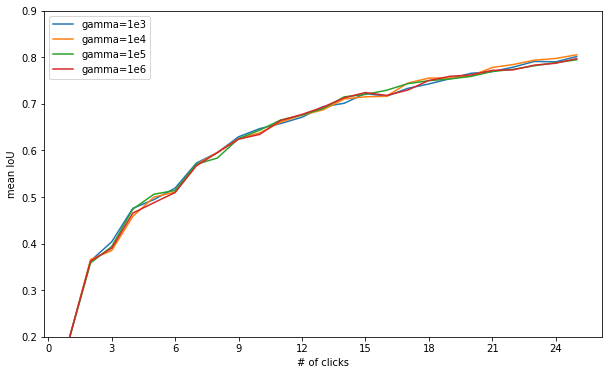

In [ ]:
res = main(iis_loader, {
    'gamma=1e3': partial(_pipeline, weights=omega_ones, grad_steps=4, gamma=1e3),
    'gamma=1e4': partial(_pipeline, weights=omega_ones, grad_steps=4, gamma=1e4),
    'gamma=1e5': partial(_pipeline, weights=omega_ones, grad_steps=4, gamma=1e5),
    'gamma=1e6': partial(_pipeline, weights=omega_ones, grad_steps=4, gamma=1e6),
}, num_batches=30)

  0%|          | 0/30 [00:00<?, ?it/s]

means
{'gamma=1e5,lr=3e-6': array([0.        , 0.22371463, 0.34468162, 0.4357348 , 0.47021803,
       0.49453016, 0.54048534, 0.561835  , 0.5924308 , 0.59935834,
       0.64212599, 0.67077742, 0.6883049 , 0.69508108, 0.71573535,
       0.7192806 , 0.73598729, 0.7419157 , 0.74615638, 0.74599799,
       0.76347343, 0.77159118, 0.78286008, 0.78830911, 0.79387791,
       0.79892686]), 'gamma=1e5,lr=1e-5': array([0.        , 0.22290019, 0.37707597, 0.40643966, 0.464969  ,
       0.51329146, 0.54388172, 0.58163715, 0.61276555, 0.63490607,
       0.6616344 , 0.68582551, 0.68919852, 0.70145492, 0.71688219,
       0.72125085, 0.7350541 , 0.74310098, 0.74677502, 0.75497155,
       0.76918848, 0.76601912, 0.7745727 , 0.78142542, 0.78864236,
       0.78381786]), 'gamma=3e5,lr=1e-5': array([0.        , 0.22484897, 0.34807333, 0.399455  , 0.46222403,
       0.51828047, 0.55077057, 0.58362231, 0.61025226, 0.63373129,
       0.66401481, 0.66679003, 0.68774873, 0.70410563, 0.71500307,
       0.71807086

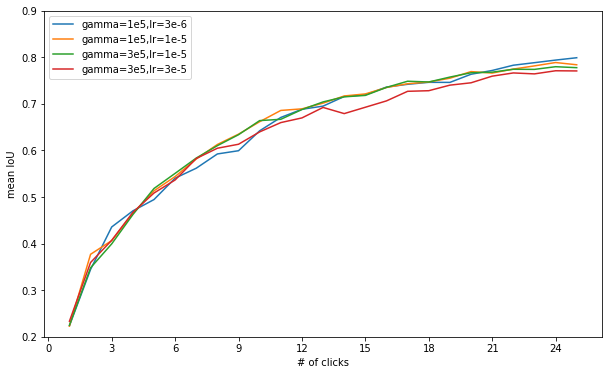

In [ ]:
res = main(iis_loader, {
    'gamma=1e5,lr=3e-6': partial(_pipeline, weights=omega_ones, grad_steps=4, gamma=1e5, lr=3e-6),
    'gamma=1e5,lr=1e-5': partial(_pipeline, weights=omega_ones, grad_steps=4, gamma=1e5, lr=1e-5),
    'gamma=3e5,lr=1e-5': partial(_pipeline, weights=omega_ones, grad_steps=4, gamma=3e5, lr=1e-5),
    'gamma=3e5,lr=3e-5': partial(_pipeline, weights=omega_ones, grad_steps=4, gamma=3e5, lr=3e-5),
}, num_batches=30)

## MAS weights

In [ ]:
res = main(iis_loader, {
    'gamma=1e5': partial(_pipeline, weights=omega, grad_steps=4, gamma=1e5),
    'gamma=1e6': partial(_pipeline, weights=omega, grad_steps=4, gamma=1e6),
    'gamma=1e7': partial(_pipeline, weights=omega, grad_steps=4, gamma=1e7),
    'gamma=1e8': partial(_pipeline, weights=omega, grad_steps=4, gamma=1e8),
}, num_batches=30)

In [ ]:
res = main(iis_loader, {
    'gamma=1e7,lr=3e-6': partial(_pipeline, weights=omega, grad_steps=4, gamma=1e7, lr=3e-6),
    'gamma=1e7,lr=1e-5': partial(_pipeline, weights=omega, grad_steps=4, gamma=1e7, lr=1e-5),
    'gamma=3e7,lr=1e-5': partial(_pipeline, weights=omega, grad_steps=4, gamma=3e7, lr=1e-5),
    'gamma=3e7,lr=3e-5': partial(_pipeline, weights=omega, grad_steps=4, gamma=3e7, lr=3e-5),
}, num_batches=30)

# Test best setup

  0%|          | 0/60 [00:00<?, ?it/s]

means
{'frozen': array([0.        , 0.22050245, 0.33588676, 0.38299535, 0.46886248,
       0.51600779, 0.54999839, 0.56805309, 0.60588792, 0.62604835,
       0.64118369, 0.676445  , 0.6794464 , 0.6865571 , 0.70504008,
       0.72679703, 0.73430844, 0.74953847, 0.75035274, 0.76039214,
       0.76951423, 0.77408334, 0.77551674, 0.78906547, 0.79883807,
       0.80335903]), 'adaptive': array([0.        , 0.23597067, 0.35727681, 0.38232502, 0.4470503 ,
       0.50007464, 0.5492138 , 0.59618055, 0.62948899, 0.66071348,
       0.67638343, 0.70168098, 0.71648621, 0.73338163, 0.73961333,
       0.75185765, 0.7590843 , 0.77240066, 0.77636041, 0.78067405,
       0.79167921, 0.79111801, 0.8019724 , 0.80600558, 0.81242626,
       0.81633286])}
area under curve
{'frozen': 15.582749816977111, 'adaptive': 16.05959945518213}
clicks@iou
[0.7, 0.75, 0.8, 0.85, 0.9]
[{'frozen': 13.15, 'adaptive': 12.366666666666667}, {'frozen': 14.966666666666667, 'adaptive': 14.0}, {'frozen': 17.85, 'adaptive': 16.466666

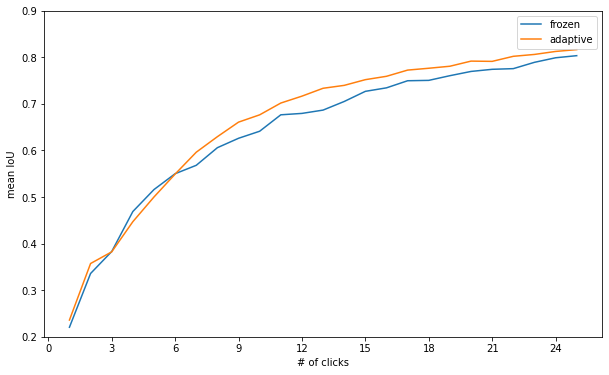

In [ ]:
res = main(iis_loader, {
    'frozen': partial(_pipeline, weights=omega, grad_steps=0),
    'adaptive': partial(_pipeline, weights=omega, grad_steps=4, gamma=1e7, lr=1e-5),
}, num_batches=60)

In [ ]:
all_res = res[0]
for k in all_res:
    all_res[k] = np.stack(all_res[k], axis=1)

ks = [10, 15, 20, 25]
for k in ks:
    diff = all_res['adaptive'][k] - all_res['frozen'][k]
    print(k, np.sum(diff > 0) / diff.shape[0])

In [ ]:
steps = [5, 10, 15, 25]
for name in res[1]:
    for k in steps:
        print(name, k, res[1][name][k])

frozen 5 0.516007794936498
frozen 10 0.6411836882432301
frozen 12 0.6794464007019997
frozen 13 0.6865570992231369
frozen 15 0.7267970348397891
frozen 25 0.8033590326706569
adaptive 5 0.5000746386746565
adaptive 10 0.676383429268996
adaptive 12 0.7164862148463726
adaptive 13 0.7333816250165304
adaptive 15 0.7518576517701149
adaptive 25 0.8163328597942988


# COCO+LVIS

## Acquire data

In [ ]:
%cd /content
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget https://github.com/saic-vul/ritm_interactive_segmentation/releases/download/v1.0/cocolvis_annotation.tar.gz
!unzip -qo train2017.zip
!unzip -qo val2017.zip
!mkdir -p CocoLvis/train
!mkdir -p CocoLvis/val
!mv train2017 CocoLvis/train/images
!mv val2017 CocoLvis/val/images
!tar xzf cocolvis_annotation.tar.gz -C CocoLvis

## Instantiate dataset

In [ ]:
seg_dataset = CocoLvisDataset(
    "/content/CocoLvis/", 
    split="val"
)
region_selector = random_single
augmentator = A.Compose([
    A.LongestMaxSize(max_size=350),
    A.Normalize(),
])
iis_dataset = RegionDataset(seg_dataset, region_selector, augmentator)

torch.manual_seed(0)
pi = torch.randperm(len(iis_dataset))
iis_dataset = Subset(iis_dataset, pi)

iis_loader = DataLoader(iis_dataset, batch_size=1, num_workers=1, shuffle=False)

## Load MAS weights for param penalty

In [ ]:
omega = torch.load('/content/drive/MyDrive/MVA/satellites/omega_bce_coco.pth')
_pipeline = partial(pipeline, model_path=model_path, weights=omega, device='cuda', interaction_steps=25)

## Test best setup

In [ ]:
res = main(iis_loader, {
    'frozen': partial(_pipeline, grad_steps=0),
    'adaptive': partial(_pipeline, grad_steps=5, gamma=3e4), 
}, num_batches=100)

In [ ]:
steps = [5, 10, 15, 25]
for name in res[1]:
    for k in steps:
        print(name, k, res[1][name][k])